In [1]:
setwd('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1009. NC ENVRIOSCAN/P1009.3. Analyses/P1009.3.4. Sociodemographic Clustering/Input')
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1009. NC ENVRIOSCAN/P1009.3. Analyses/P1009.3.4. Sociodemographic Clustering/Output')
cur_date = "010723"

library(readxl)
library(tidyverse)
library(reshape2)
library(Hmisc)
library(factoextra)

# reading in files
acs_whp_df = data.frame(read_excel("010523_Imputed_ACS_WHP_Data.xlsx")) %>%
    # removing uneeded variables
    select(-c("Avg_ACRES", "Wildfire_Hazard_Potential_Quintile_Percentage")) 
# converting quintile col into a character
acs_whp_df$Wildfire_Hazard_Potential_Quintile_Number = as.character(acs_whp_df$Wildfire_Hazard_Potential_Quintile_Number)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Loading required package: lattice

Loading required package: survival

Loading required package: Formula


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following objects are masked from ‘package:base’:

    format.pval, units


Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



In [2]:
head(acs_whp_df)

,GEO_ID,Census_Tract,County,Wildfire_Hazard_Potential_Mean,Wildfire_Hazard_Potential_Quintile_Number,Sex_Ratio,Median_Age,Population_Under_18,Population_Over_18,Population_Over_65,⋯,Poverty_Adult,Poverty_Elderly,Poverty_Male,Poverty_Female,Poverty_Black,Poverty_Asian,Poverty_Other_Race,Poverty_Mixed_Race,Poverty_Hispanic_Latino,Poverty_White
,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,14000US37001020100,201.00,Alamance,92.23704,1,87.2,37.3,21.9,78.1,15.1,⋯,20.8,14.6,26.4,28.0,54.8,0.000,45.3,0.0,31.3,13.9
2,14000US37001020200,202.00,Alamance,92.23704,1,78.3,31.0,29.1,70.9,11.2,⋯,33.0,19.2,27.3,37.8,44.6,0.000,0.0,82.7,16.2,39.0
3,14000US37001020300,203.00,Alamance,92.23704,1,77.8,40.7,27.1,72.9,18.9,⋯,17.3,22.0,18.0,28.3,21.0,31.302,10.9,36.4,26.7,20.1
4,14000US37001020400,204.00,Alamance,92.23704,1,78.1,30.5,31.4,68.6,10.1,⋯,26.8,14.0,30.0,33.3,19.9,22.276,69.0,100.0,67.2,26.6
5,14000US37001020501,205.01,Alamance,92.23704,1,92.7,35.1,23.3,76.7,15.6,⋯,12.2,7.1,12.3,14.8,18.9,0.000,0.0,53.1,25.7,10.0
6,14000US37001020502,205.02,Alamance,92.23704,1,99.0,32.1,30.0,70.0,8.9,⋯,22.3,19.2,17.7,31.0,27.8,100.000,14.2,19.5,14.7,25.0


This analysis will use PCA & k means to explore 2 research questions:
1. Is there is an association between sociodemographic variables and wildfire hazard potential?
2. Do certain sociodemographic variables cluster more closely together?

In [3]:
#creating correlation matrix
corr_matrix = rcorr(as.matrix(acs_whp_df[6:32]), type = "spearman")
#creating df where I can easily view coefficents that are highly correlated (rho > 0.7 or rho < -0.7)
corr_matrix_df = data.frame(corr_matrix$r) %>%
  rownames_to_column(var = "Variable1") %>%
  #needed to specificy package of melt for it to work
  reshape2::melt(variable = "Variable2", value.name = "Spearman Coefficient") %>%
  #also removed values = 1, because those were correlations between the same variable
  filter(abs(`Spearman Coefficient`) < 1 & abs(`Spearman Coefficient`) > 0.7) %>%
  arrange(desc(`Spearman Coefficient`)) %>%
  #removing duplicate spearman coefficient values and keeping all columns
  distinct(`Spearman Coefficient`, .keep_all = TRUE) 

corr_matrix_df

Using Variable1 as id variables



Variable1,Variable2,Spearman Coefficient
<chr>,<fct>,<dbl>
Poverty_Female,Poverty_Overall,0.9710088
Poverty_Adult,Poverty_Overall,0.9628447
Poverty_Male,Poverty_Overall,0.9586292
Poverty_Female,Poverty_Adult,0.9294126
Poverty_Male,Poverty_Adult,0.9287556
Poverty_Children,Poverty_Overall,0.8861192
Poverty_Female,Poverty_Male,0.8700468
Poverty_Female,Poverty_Children,0.8669162
Population_Over_65,Median_Age,0.8467985


Some of these variables are a bit redundant as is evidenced by the correlation coefficients, so let's remove those to reduce multicollinearity in our models. Multicollinearity is an issue, because it dampens the importance of variables in models, making them seem less significant. Therefore, the following variables will be removed:
- female, male, children, and adult poverty
- english speakers only
- hispanic/latino
- population over 18 & 65
- race black

# Principal Component Analysis (PCA)
First using PCA to see if and how the WHP quintiles cluster based on the compressed variance or data for the sociodemographic variables.

In [68]:
# prepping df
sociodemographic_pca_prep_df = acs_whp_df[,c(1,7:32)] %>%
    # removing variables that were highly correlated, redundant, or not very relevant to WHP
#     select(-c("Poverty_Female", "Poverty_Male", "Poverty_Adult", "Poverty_Children", "English_Speakers_Only", 
#               "Population_Over_18", "Population_Over_65", "Hispanic_Latino", "Sex_Ratio")) %>%
    column_to_rownames(var = "GEO_ID")

# psudeo log transforming makes the data have a more a normal distribution
# it also centers and scales the data, which is necessary for PCA

#sociodemographic_pca_prep_df = log2(sociodemographic_pca_prep_df + 1) 

head(sociodemographic_pca_prep_df)

,Median_Age,Population_Under_18,Population_Over_18,Population_Over_65,Race_White,Race_Black,Race_Indigenous,Race_Asian,Race_Other,Race_Mixed,⋯,Poverty_Adult,Poverty_Elderly,Poverty_Male,Poverty_Female,Poverty_Black,Poverty_Asian,Poverty_Other_Race,Poverty_Mixed_Race,Poverty_Hispanic_Latino,Poverty_White
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
14000US37001020100,37.3,21.9,78.1,15.1,61.0,28.5,0.3,1.8,6.5,1.9,⋯,20.8,14.6,26.4,28.0,54.8,0.000,45.3,0.0,31.3,13.9
14000US37001020200,31.0,29.1,70.9,11.2,51.9,29.2,0.9,4.4,11.7,1.8,⋯,33.0,19.2,27.3,37.8,44.6,0.000,0.0,82.7,16.2,39.0
14000US37001020300,40.7,27.1,72.9,18.9,45.2,28.9,0.0,0.0,23.1,2.9,⋯,17.3,22.0,18.0,28.3,21.0,31.302,10.9,36.4,26.7,20.1
14000US37001020400,30.5,31.4,68.6,10.1,19.6,59.0,0.2,0.0,19.9,1.4,⋯,26.8,14.0,30.0,33.3,19.9,22.276,69.0,100.0,67.2,26.6
14000US37001020501,35.1,23.3,76.7,15.6,76.1,13.3,0.0,1.4,8.3,0.8,⋯,12.2,7.1,12.3,14.8,18.9,0.000,0.0,53.1,25.7,10.0
14000US37001020502,32.1,30.0,70.0,8.9,40.7,35.7,0.0,2.3,15.1,6.2,⋯,22.3,19.2,17.7,31.0,27.8,100.000,14.2,19.5,14.7,25.0


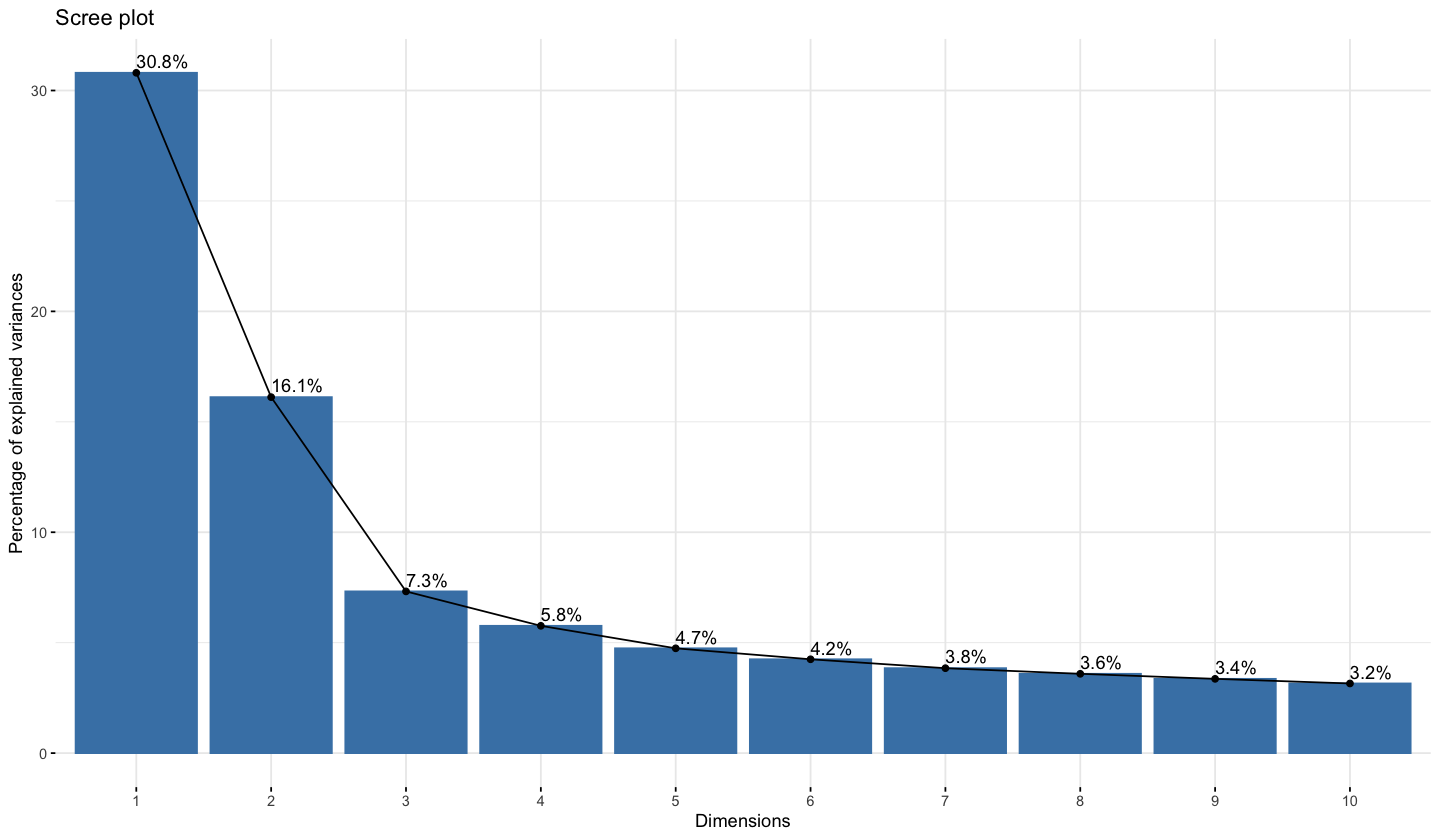

In [69]:
# running pca 
pca_sociodemographic_data = prcomp(sociodemographic_pca_prep_df, scale = TRUE, center = TRUE)

# looking a scree plot to see how much of the variance was captured in first 2 eigenvectors
options(repr.plot.width = 12, repr.plot.height = 7) #changing size
fviz_eig(pca_sociodemographic_data, addlabels = TRUE)

I NEED TO FIGURE OUT WHY PCA PERFORMS BETTER ON PERCENTAGES WITH NON-CENTERED AND SCALED DATA!!!!

Warning message:
“ggrepel: 2176 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


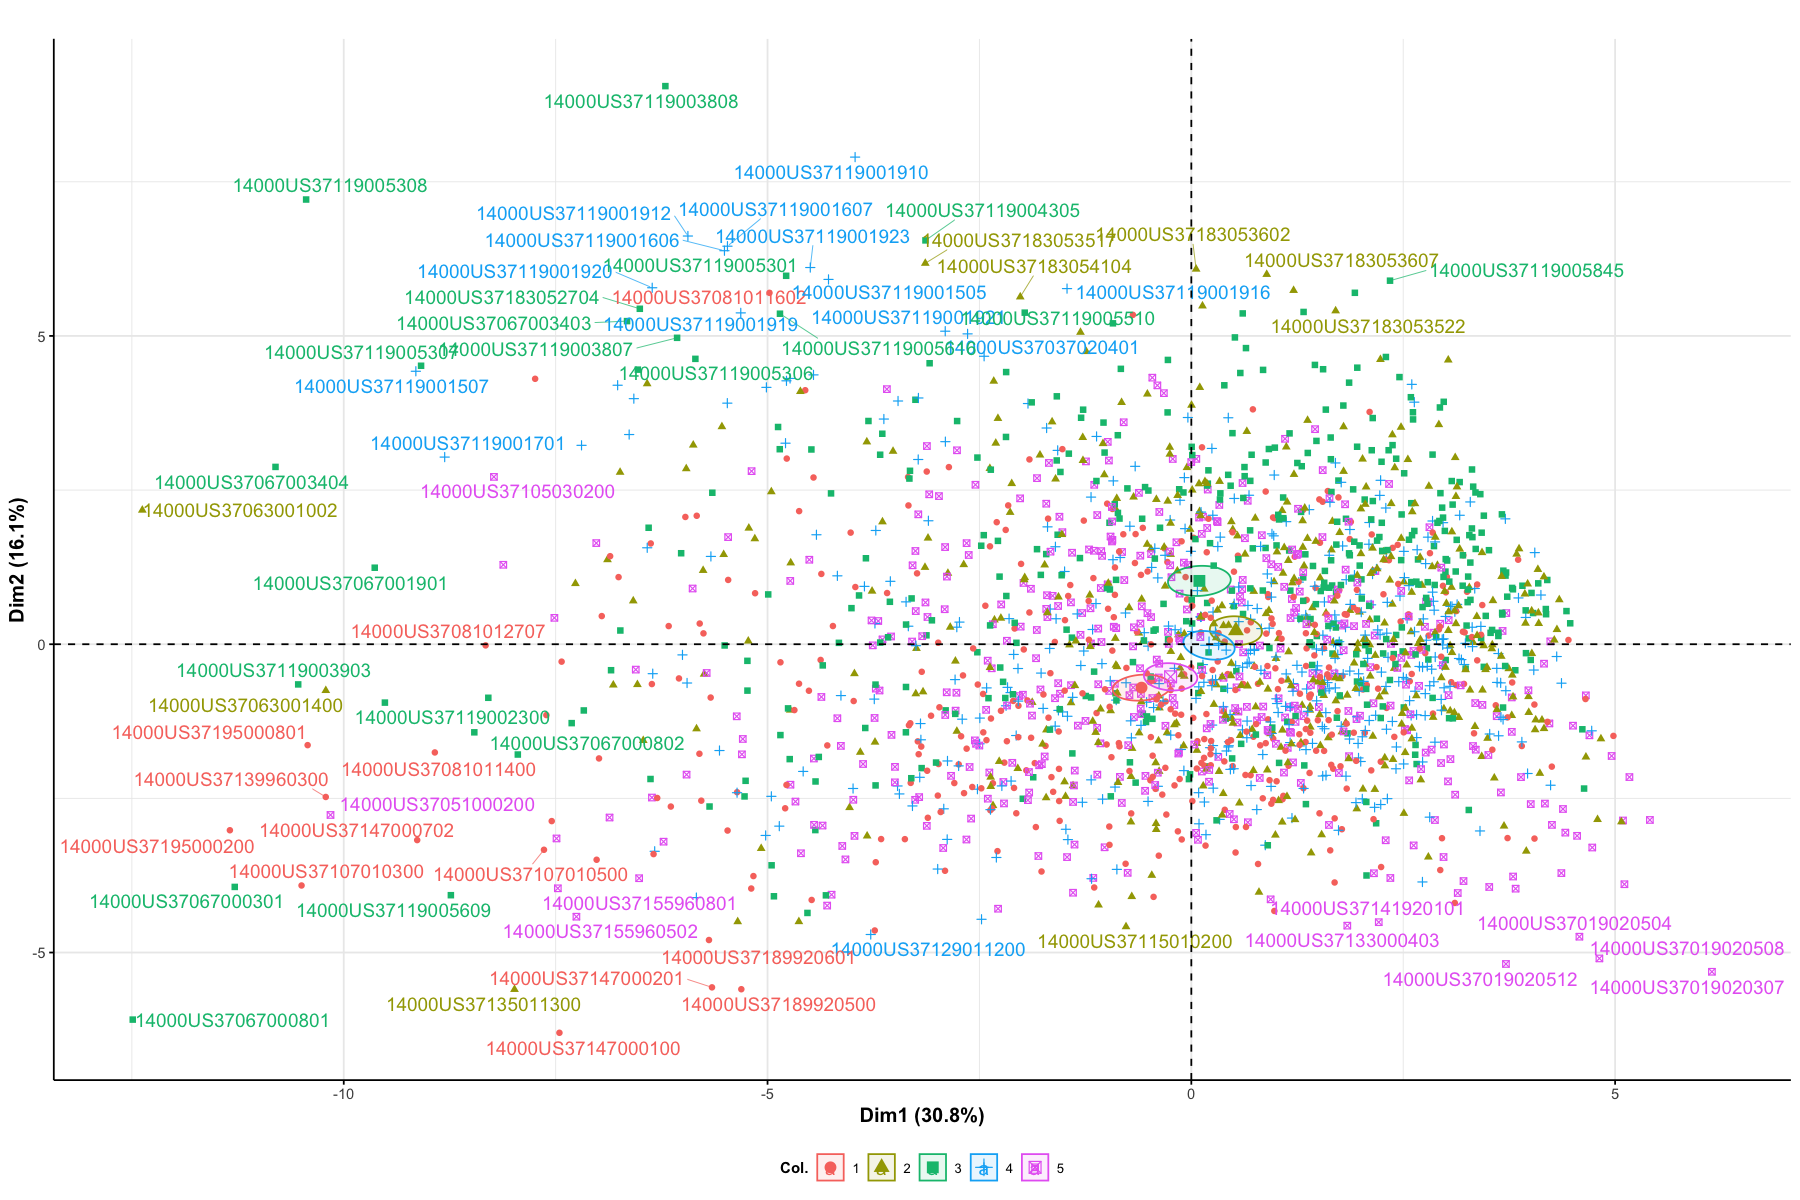

In [57]:
# visualizing all data to detect outlier subjects
options(repr.plot.width = 15, repr.plot.height = 10) #changing size
fviz_pca_ind(pca_sociodemographic_data, 
             col.ind = as.character(acs_whp_df$Wildfire_Hazard_Potential_Quintile_Number), # color quintile
             #adding 95% confidence ellipses for each group
             addEllipses = TRUE, # Concentration ellipses
             ellipse.type = "confidence",
             repel = TRUE, title = "") +
theme(axis.line = element_line(colour = "black"), #making x and y axes black
      legend.title = element_text(size = 9, face = "bold"),
      legend.text = element_text(size = 8),
      legend.position = 'bottom',
      axis.title = element_text(face = "bold", size = rel(1.1))) #changes axis titles

Now determining contributions of each contribution on the first two eigenvectors.

Warning message:
“ggrepel: 2 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


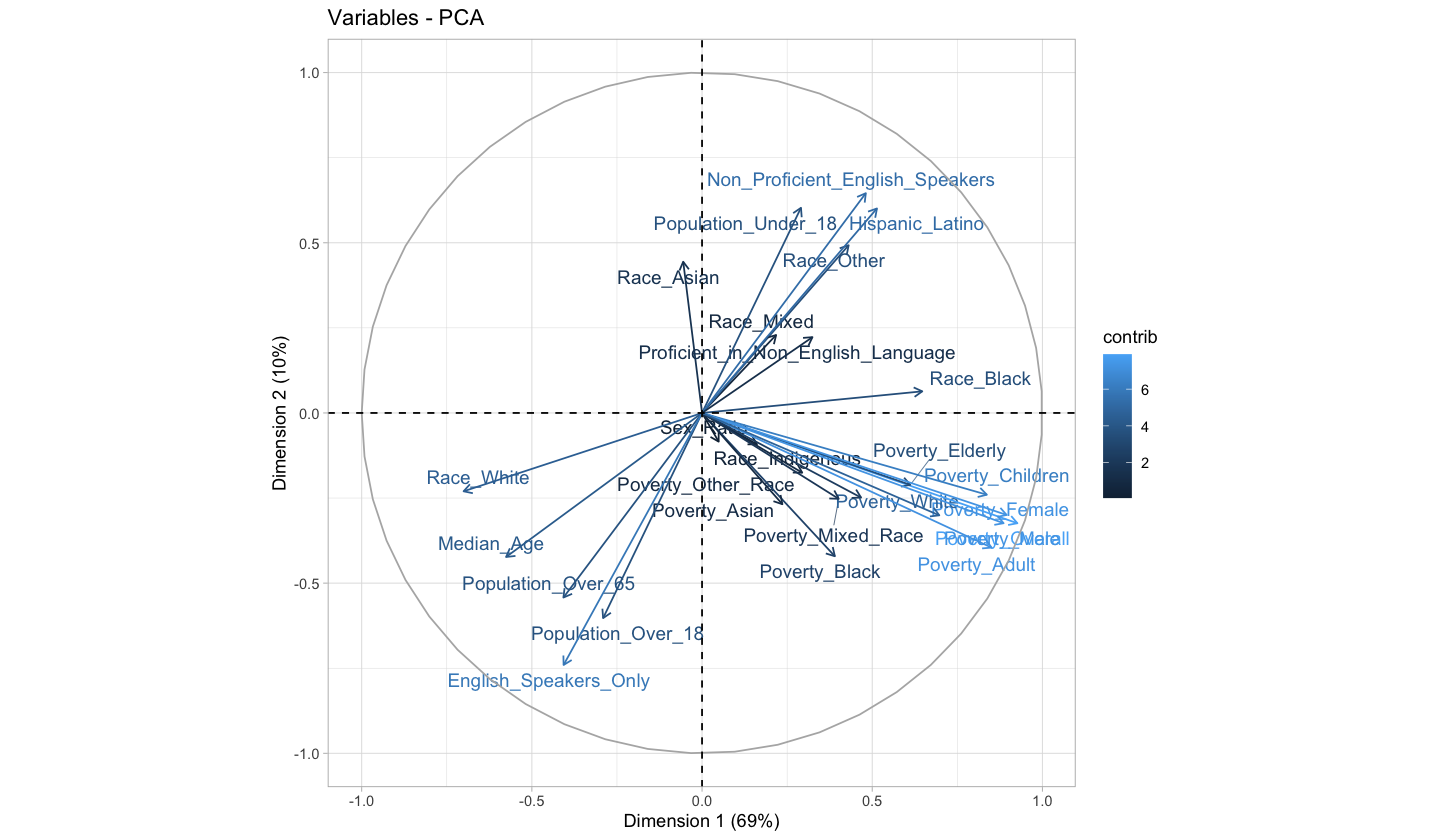

In [33]:
options(repr.plot.width=12, repr.plot.height=7) #changing size
# choosing colors
#brewer_colors = brewer.pal(10, "PuOr")

fviz_pca_var(pca_sociodemographic_data, col.var = "contrib", repel = TRUE) +
  xlab('Dimension 1 (69%)') + ylab('Dimension 2 (10%)') + #changing axis labels
  theme_light() #+ 

#  # changing colors
#  scale_color_gradient2(name = "Contribution", low = brewer_colors[1], mid = "white", high = brewer_colors[10], 
#                       midpoint = 25) 

It's hard to see everything at the bottom, so I made a bar chart below that contains the same information. However, it only shows contributions from the first eigenvector.

In [34]:
loadings = data.frame(pca_sociodemographic_data$rotation) %>%
  rownames_to_column(var = "Variable") %>%
  select(Variable, PC1, PC2) %>%
  pivot_longer(cols = c("PC1", "PC2"), names_to = "PC", values_to = "Loading") %>%
  # adding an additional bogus col for the later heat map to work
  mutate(Category = "Variable")

head(loadings)

Variable,PC,Loading,Category
<chr>,<chr>,<dbl>,<chr>
Sex_Ratio,PC1,0.01724741,Variable
Sex_Ratio,PC2,-0.04114853,Variable
Median_Age,PC1,-0.20345023,Variable
Median_Age,PC2,-0.20659527,Variable
Population_Under_18,PC1,0.10271588,Variable
Population_Under_18,PC2,0.29427315,Variable


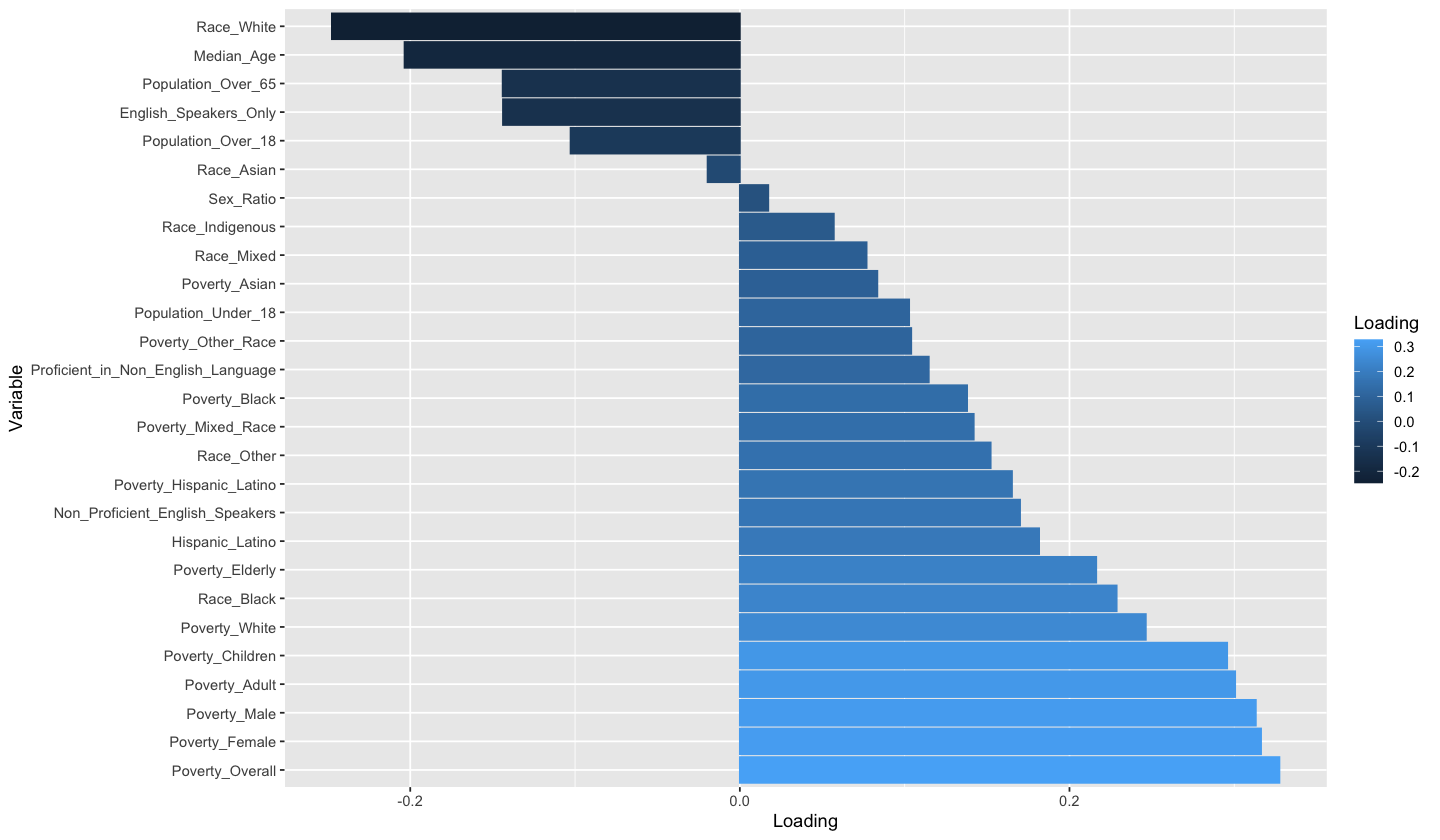

In [35]:
ggplot(loadings %>%
         #filtering for PC1 
         filter(PC == "PC1"), 
       aes(y = reorder(Variable, -Loading), x = Loading, color = Loading, fill = Loading)) + 
  geom_bar(stat = "identity") + 

#   # changing color
#   scale_color_gradient2(low = brewer_colors[1], mid = "white", high = brewer_colors[10]) +
#   scale_fill_gradient2(low = brewer_colors[1], mid = "white", high = brewer_colors[10]) +
   ylab("Variable")

It's hard to see what clusters if any are present, so I'll see if some of those outlier GEO ids can be removed so the clusters can be more easily seen. 

In [36]:
outlier_detection = function(pca_df){
    # """
    # Creating a scoring function for to detect PCA subject outliers. 
    # :param (input): PCA df (df)
    # :output: outlier names
    # """
    
    # getting scores
    scores = pca_df$x[,1:2]
    # identifying samples that are > 6 standard deviations away from the mean
    outlier_indices = apply(scores, 2, function(x) which( abs(x - mean(x)) > (6 * sd(x)) )) %>%
        Reduce(union, .)
    # getting sample names
    outliers = rownames(scores)[outlier_indices]
    
    return(outliers)
}

# calling fn
id_outliers = outlier_detection(pca_sociodemographic_data)
id_outliers

character(0)

In [15]:
# removing those 6 outliers 
`%notin%` <- Negate(`%in%`)

removed_outliers_df = sociodemographic_pca_prep_df %>%
    filter(row.names(sociodemographic_pca_prep_df) %notin% id_outliers)
head(removed_outliers_df)

,Sex_Ratio,Median_Age,Population_Under_18,Population_Over_18,Population_Over_65,Race_White,Race_Black,Race_Indigenous,Race_Asian,Race_Other,⋯,Poverty_Adult,Poverty_Elderly,Poverty_Male,Poverty_Female,Poverty_Black,Poverty_Asian,Poverty_Other_Race,Poverty_Mixed_Race,Poverty_Hispanic_Latino,Poverty_White
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
14000US37001020100,87.2,37.3,21.9,78.1,15.1,61.0,28.5,0.3,1.8,6.5,⋯,20.8,14.6,26.4,28.0,54.8,0.000,45.3,0.0,31.3,13.9
14000US37001020200,78.3,31.0,29.1,70.9,11.2,51.9,29.2,0.9,4.4,11.7,⋯,33.0,19.2,27.3,37.8,44.6,0.000,0.0,82.7,16.2,39.0
14000US37001020300,77.8,40.7,27.1,72.9,18.9,45.2,28.9,0.0,0.0,23.1,⋯,17.3,22.0,18.0,28.3,21.0,31.302,10.9,36.4,26.7,20.1
14000US37001020400,78.1,30.5,31.4,68.6,10.1,19.6,59.0,0.2,0.0,19.9,⋯,26.8,14.0,30.0,33.3,19.9,22.276,69.0,100.0,67.2,26.6
14000US37001020501,92.7,35.1,23.3,76.7,15.6,76.1,13.3,0.0,1.4,8.3,⋯,12.2,7.1,12.3,14.8,18.9,0.000,0.0,53.1,25.7,10.0
14000US37001020502,99.0,32.1,30.0,70.0,8.9,40.7,35.7,0.0,2.3,15.1,⋯,22.3,19.2,17.7,31.0,27.8,100.000,14.2,19.5,14.7,25.0


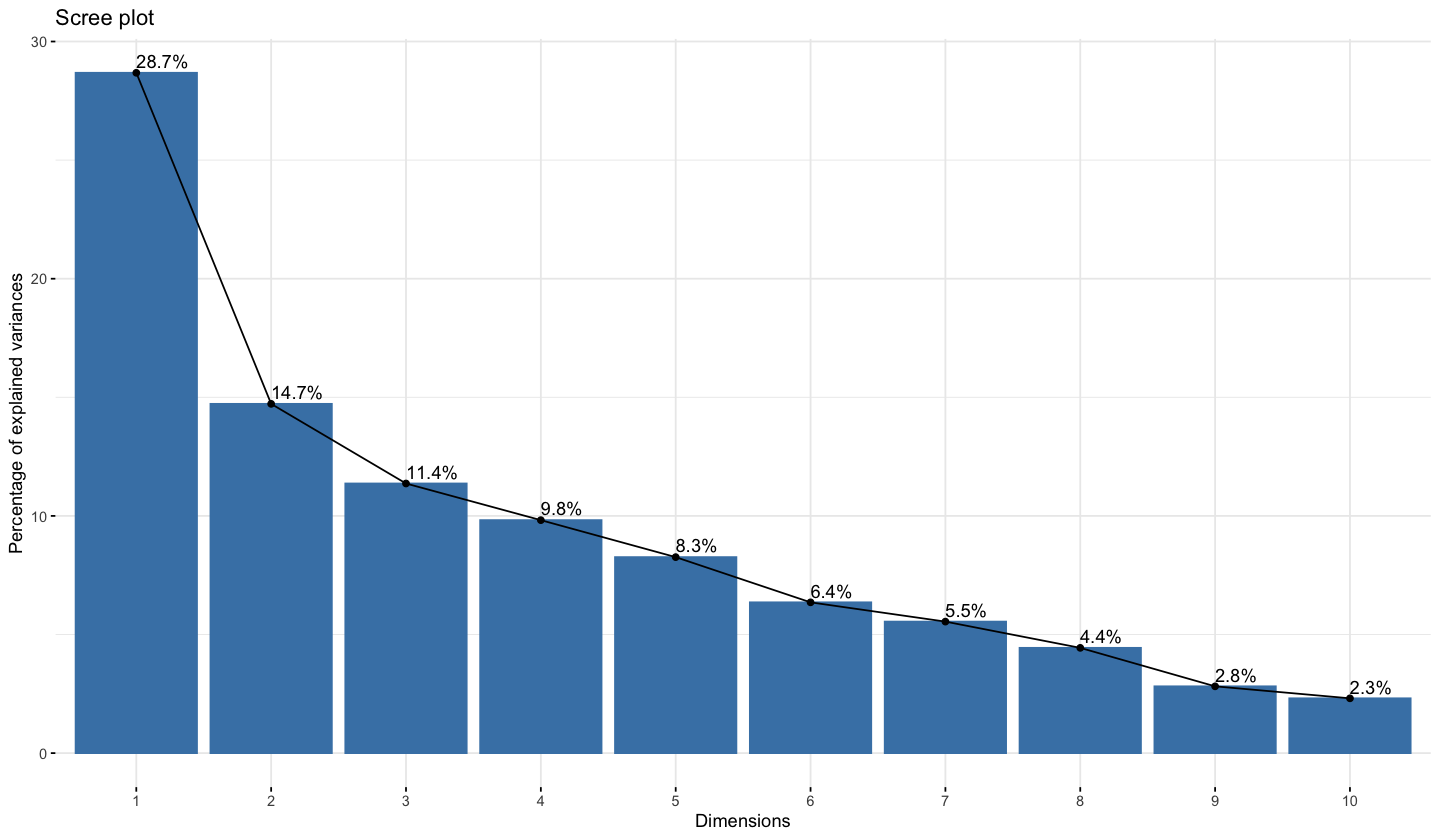

In [16]:
# rerunning PCA
removed_outliers_pca_sociodemographic_data = prcomp(removed_outliers_df)

# looking a scree plot to see how much of the variance was captured in first 2 eigenvectors
options(repr.plot.width = 12, repr.plot.height = 7) #changing size
fviz_eig(removed_outliers_pca_sociodemographic_data, addlabels = TRUE)